In [1]:
# Import neccessary Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [2]:
# Data Ingestion 
pets_prepared_df = pd.read_csv('/Users/vaishnavikennedy/Downloads/data/pets_prepared.csv')
breed_labels_df =  pd.read_csv('/Users/vaishnavikennedy/Downloads/data/breed_labels.csv') 
state_labels_df = pd.read_csv('/Users/vaishnavikennedy/Downloads/data/state_labels.csv') 
color_labels_df = pd.read_csv('/Users/vaishnavikennedy/Downloads/data/color_labels.csv') 
pets_prepared_df.head(5)

,PetID,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,HealthName,VaccinatedName,DewormedName,SterilizedName,BreedName,BreedBinsName,StateName,StateBinsName,ColorName,AdoptedName
0,86e1089a3,2,2,Nibble,3,299,0,1,1,7,...,Healthy,No,No,No,Tabby,Tabby,Selangor,Selangor,Black,Y
1,6296e909a,0,2,No Name Yet,1,265,0,1,1,2,...,Healthy,Not Sure,Not Sure,Not Sure,Domestic Medium Hair,Domestic Medium Hair,Kuala Lumpur,Kuala Lumpur,Black,Y
2,3422e4906,3,1,Brisco,1,307,0,1,2,7,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Brown,Y
3,5842f1ff5,2,1,Miko,4,307,0,2,1,2,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Kuala Lumpur,Kuala Lumpur,Black,Y
4,850a43f90,2,1,Hunter,1,307,0,1,1,0,...,Healthy,No,No,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Black,Y


In [3]:
# Data Basic Info 
pets_prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PetID             14993 non-null  object
 1   AdoptionSpeed     14993 non-null  int64 
 2   Type              14993 non-null  int64 
 3   Name              14993 non-null  object
 4   Age               14993 non-null  int64 
 5   Breed1            14993 non-null  int64 
 6   Breed2            14993 non-null  int64 
 7   Gender            14993 non-null  int64 
 8   Color1            14993 non-null  int64 
 9   Color2            14993 non-null  int64 
 10  Color3            14993 non-null  int64 
 11  MaturitySize      14993 non-null  int64 
 12  FurLength         14993 non-null  int64 
 13  Vaccinated        14993 non-null  int64 
 14  Dewormed          14993 non-null  int64 
 15  Sterilized        14993 non-null  int64 
 16  Health            14993 non-null  int64 
 17  Quantity    

___MISSING VALUES, DTYPE, SHAPE, TARGET___

<div class="alert alert-block alert-info">
    
        - Missing Values : 0
        - Dtypes : integer(22) and Object(27 features)
        - Shape : Rows 14993, Columns : 49 
        - Target : AdoptionSpeed

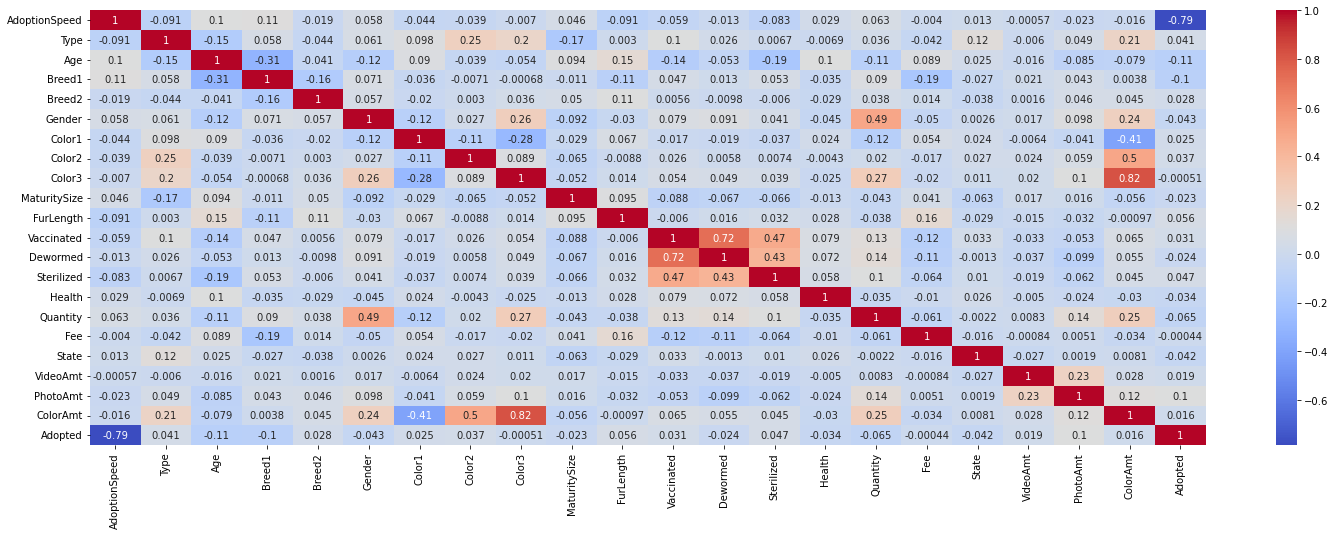

In [4]:
# Correlation matrix
corr_matrix=pets_prepared_df.corr()
plt.figure(figsize=(25,8))  # correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

___FEATURE INTERACTION - CORRELATION , REDUNDANT, UNIQUE ID VALUES___

<div class="alert alert-block alert-info">
- correlated_features= ['Color3','Vaccinated', 'Dewormed'], evident from heatmap correlated features
- From the data dictionary, it is eveident that below list of fields "drop_fields" are redundant or is used to derive bins or represented in another form or is unique set of identities such as PetID,Rescuer ID,Name etc..
- drop_fields=['PetID','Name', 'State','Age','Fee','Breed1', 'Breed2','RescuerID', 'VideoAmt', 'PhotoAmt', 'Description', 'TypeName', 'GenderName', 'MaturitySizeName', 'FurLengthName','HealthName', 'VaccinatedName', 'DewormedName', 'SterilizedName','BreedName', 'StateBinsName','StateName','Quantity','AdoptedName']
      I will use these featured to configure drop_fields in the ML pipeline since presence of such columns can possiblydecrease performance. However, not depend on the correlation alone. will handle this in the ML pipeline along with feature importance

In [5]:
# Remove Redundant Columns and unwanted columns
drop_fields=["PetID","Name","Age","Breed1","Breed2","VideoAmt","PhotoAmt","Fee","State",
              "RescuerID","Description","TypeName","GenderName","MaturitySizeName",
              "FurLengthName","HealthName","DewormedName","Color1","Color2","Color3",
              "VaccinatedName","BreedName","StateName","Quantity","AdoptedName",
              "StateBinsName","SterilizedName"]
pets_prepared_df=pets_prepared_df.drop(columns=drop_fields,axis=1)

In [6]:
# Duplicates
duplicates_count = pets_prepared_df.duplicated().sum()
pets_prepared_df = pets_prepared_df.drop_duplicates(keep='first')

___DUPLICATES IN DF___

<div class="alert alert-block alert-info">
    
        Number of Duplicate rows is 649
        Remove these in the ML pipeline since they affect the performance of the value (drop by keeping first) 

In [7]:
# Statistical Exploration
pets_prepared_df.describe()

,AdoptionSpeed,Type,Gender,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,ColorAmt,Adopted
count,14344.000000,14344.000000,14344.000000,14344.000000,14344.000000,14344.000000,14344.000000,14344.000000,14344.000000,14344.000000,14344.000000
mean,2.515198,1.469116,1.778862,1.859314,1.472602,1.735011,1.561350,1.912507,1.038274,2.002858,0.717652
std,1.182641,0.499063,0.686853,0.555508,0.603115,0.668709,0.697103,0.572511,0.203844,0.771308,0.450157
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000
max,4.000000,2.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000


___OUTLIER ANALYSIS___

<div class="alert alert-block alert-info">
       
   - .50% row indicates the 50 th percentile of the featurte, that is, MEDIAN of each column. As we can see mean and the median values are not significantly different. This implies data is NOT SKEWED
   - For almost all the features, Max value is not very much higher than 75% and this indicates not much of Outliers 
   - However since most of the features are almost like categorical features,we need to handle outliers based on finding rare categories by calulating frequency of each category.


___FEATURE SCALING___

<div class="alert alert-block alert-info">
       
   - Since the range of values of the features is between 0-5 and doesnt vary much. There is no neccessary for feature scaling.

___FIRST LEVEL DATA DISTRIBUTION INSIGHTS___

<div class="alert alert-block alert-info">

   - Most animals have an adoption speed of 2, indicating a moderate adoption rate.More animals of Type 1 are up for adoption compared to Type 2.Most animals have a maturity size of 2, with fewer animals at the extremes.Most animals have fur length of 1 or 2, with relatively fewer having fur length 3. vaccination status of most of the pets are known and relatively less pet's vaccination status is unknown.Most of the pets are in good health and are sterlized as well. When it comes to colour of the pet most of the pets have 2 colours  and the distribution is even.There are more adopted pets and less unadopted pets in the petcenter.

In [8]:
# Feature engineering - Adding new feature
pets_df = pd.read_csv('/Users/vaishnavikennedy/Downloads/data/pets_prepared.csv')
rescuer_popularity = pets_df['RescuerID'].value_counts()
pets_df['RescuerPopularity'] = pets_df['RescuerID'].map(rescuer_popularity)

___FEATURE ENGINEERING ADDED NEW FEATURE - RESCUERPOPULARITY___

<div class="alert alert-block alert-info">
       
   - New feature added called as RescuerPopularity and on seeing the distribution we need to normalise the feature while creating in the ML pipeline such as rescuer_popularity = pets_df['RescuerID'].value_counts()

In [9]:
#Variance of Feature 
pets_prepared_df.var()

/var/folders/mq/r38gxv852m588tryt1t04wlw0000gn/T/ipykernel_2432/1525901733.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pets_prepared_df.var()


AdoptionSpeed    1.398640
Type             0.249064
Gender           0.471767
MaturitySize     0.308589
FurLength        0.363748
Vaccinated       0.447171
Dewormed         0.485952
Sterilized       0.327769
Health           0.041553
ColorAmt         0.594916
Adopted          0.202642
dtype: float64

___FEATURE SELECTION : VARIANCE OF THE FEATURE___

<div class="alert alert-block alert-info">

  - AdoptionSpeed has the highest variance,this variability is expected since it is target variable. ColorAmt has the second highest variance.Type, MaturitySize, FurLength, Gender,Adopted and Health have low variance     

___LABEL ENCODING AND FEATURE INPUT___

<div class="alert alert-block alert-info">

 -As a data prep step, Label encoding and using selectKbest model for looking into good features that could be Feature Input to Model 


In [10]:
#LabelEncoding
categorical_cols = pets_prepared_df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    pets_prepared_df[col] = le.fit_transform(pets_prepared_df[col])

In [11]:
#Feature Input - Feature Selection
k = 20
x = pets_prepared_df.drop(columns=['AdoptionSpeed'])
y = pets_prepared_df['AdoptionSpeed']
selector = SelectKBest(chi2, k=k)
selector.fit(x, y)
select_features = x.columns[selector.get_support()]

___GOOD FEATURE INPUTS TOP 20___

<div class="alert alert-block alert-info">
 - Top 20 good features for prediction are ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'AgeBins', 'FeeBins', 'BreedBins', 'StateBins',
       'VideoAmtBins', 'PhotoAmtBins', 'QuantityBins', 'BreedPure', 'ColorAmt',
       'NameorNO', 'Adopted', 'BreedBinsName', 'ColorName']

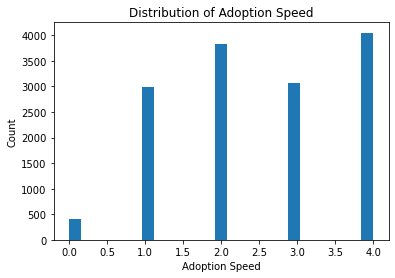

4    4050
2    3835
3    3076
1    2980
0     403
Name: AdoptionSpeed, dtype: int64

In [12]:
#Distribution of Target Variable
plt.hist(pets_prepared_df['AdoptionSpeed'], bins=25)  
plt.xlabel('Adoption Speed')
plt.ylabel('Count')
plt.title('Distribution of Adoption Speed')
plt.show()
pets_prepared_df['AdoptionSpeed'].value_counts()

___DISTRIBUTION OF TARGET : DATA IMBALANCE IN THE TARGET VARIABLE___

<div class="alert alert-block alert-info">
 - It is evident from above histogram that the target variable class is imbalnced. The 0 class of the adoptionspeed is very low. Have to handle this imbalance in target variable in ML pipeline to resample the training dataset.

/var/folders/mq/r38gxv852m588tryt1t04wlw0000gn/T/ipykernel_2432/598330043.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Description'] = data['Description'].str.replace('[^a-zA-Z0-9\s]', '') # Remove special characters


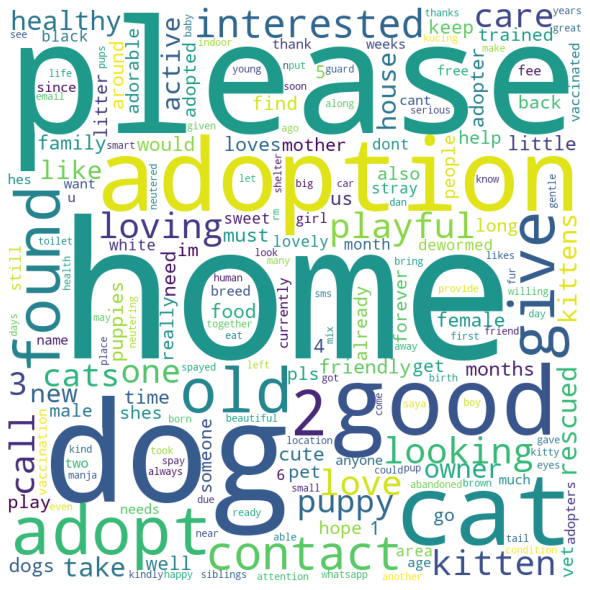

the distribution of the sentiments in the DF is 
  Neutral     11586
Positive     3367
Negative       40
Name: sentiment, dtype: int64


/Users/vaishnavikennedy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The top words in each topic set is : 
Topic #0:
home puppy pls forever looking adopt contact interested forever home cute
Topic #1:
cat kitten trained playful active food litter healthy toilet white
Topic #2:
dan saya kucing dia yang di untuk ni yg adopt
Topic #3:
cat home old cats months kittens months old care loving adopt
Topic #4:
adoption contact interested free female old kindly male months location
Topic #5:
home good dog loving dogs owner good home family looking new
Topic #6:
fee rm adoption adoption fee vaccination spaying neutering long adopter caging
Topic #7:
puppies mother dog adopt birth help home puppy gave area
Topic #8:
loves little like hes play home love shes people playful
Topic #9:
dog care owner adopt house love im dont want good


In [13]:
# Import necessary libraries
# Load the data into a pandas dataframe
data = pd.read_csv('/Users/vaishnavikennedy/Downloads/data/pets_prepared.csv')
# Basic text preprocessing
data['Description'] = data['Description'].fillna('') # Fill NaN values with empty string
data['Description'] = data['Description'].str.lower() # Convert text to lowercase
data['Description'] = data['Description'].str.replace('[^a-zA-Z0-9\s]', '') # Remove special characters
stop_words = set(stopwords.words('english')) # Create a set of stop words
data['Description'] = data['Description'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words)) # Remove stop words
data['Description'] = data['Description'].apply(nltk.word_tokenize) # Tokenize the text data
# Word frequency analysis
word_count = pd.Series(np.concatenate(data['Description'])).value_counts()
common_words = word_count[:30]
rare_words = word_count[-30:]
# Word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate_from_frequencies(word_count)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
# Sentiment analysis
data['polarity'] = data['Description'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
data['sentiment'] = pd.cut(data['polarity'], bins=3, labels=['Negative', 'Neutral', 'Positive'])
print("the distribution of the sentiments in the DF is \n ",data['sentiment'].value_counts() )
# Topic modeling
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(data['Description'].apply(lambda x: ' '.join(x)))
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)
features = vectorizer.get_feature_names()
print("The top words in each topic set is : ")
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([features[i] for i in topic.argsort()[:-10 - 1:-1]]))


___ASSUMPTIONS SUPPORTING EDA: DESCRIPTION FEATURE DROPPING___

<div class="alert alert-block alert-info">
 - The above EDA shows the wordcloud and the words are the common words that one can expect in any pet adoption description. On conducting sentimennt analysis , it is found that majoriy of the description is neutral about 11587 rows, Positive is  3367 rows and negative sentiment of 30. There is huge imbalnce in this feature. Also, looking at set of top words in each topic set obtained from topic modelling , also shows very commonly used words. Hence this feature can be completely dropped and may not be included in the ML pipeline.Another challengfe is mix of language.  


___FEATURE IMPORTANCE CONDUCTED : TOP10 IMPACTFUL FEATURES : OBTAINED FROPM THE BEST MODEL : INSIGHT INTO ADOPTER PREFERENCE___

<div class="alert alert-block alert-info">
 - Top 10 Features after modelling that is found impactful features for adopter's preference ['Adopted', 'PhotoAmtBins', 'AgeBins', 'RescuerPopularity', 'StateBins', 'ColorName', 'Gender', 'ColorAmt', 'FurLength', 'Dewormed']
    The feature importance obtained during the ML pipeline with best model CAtboost and best parameters



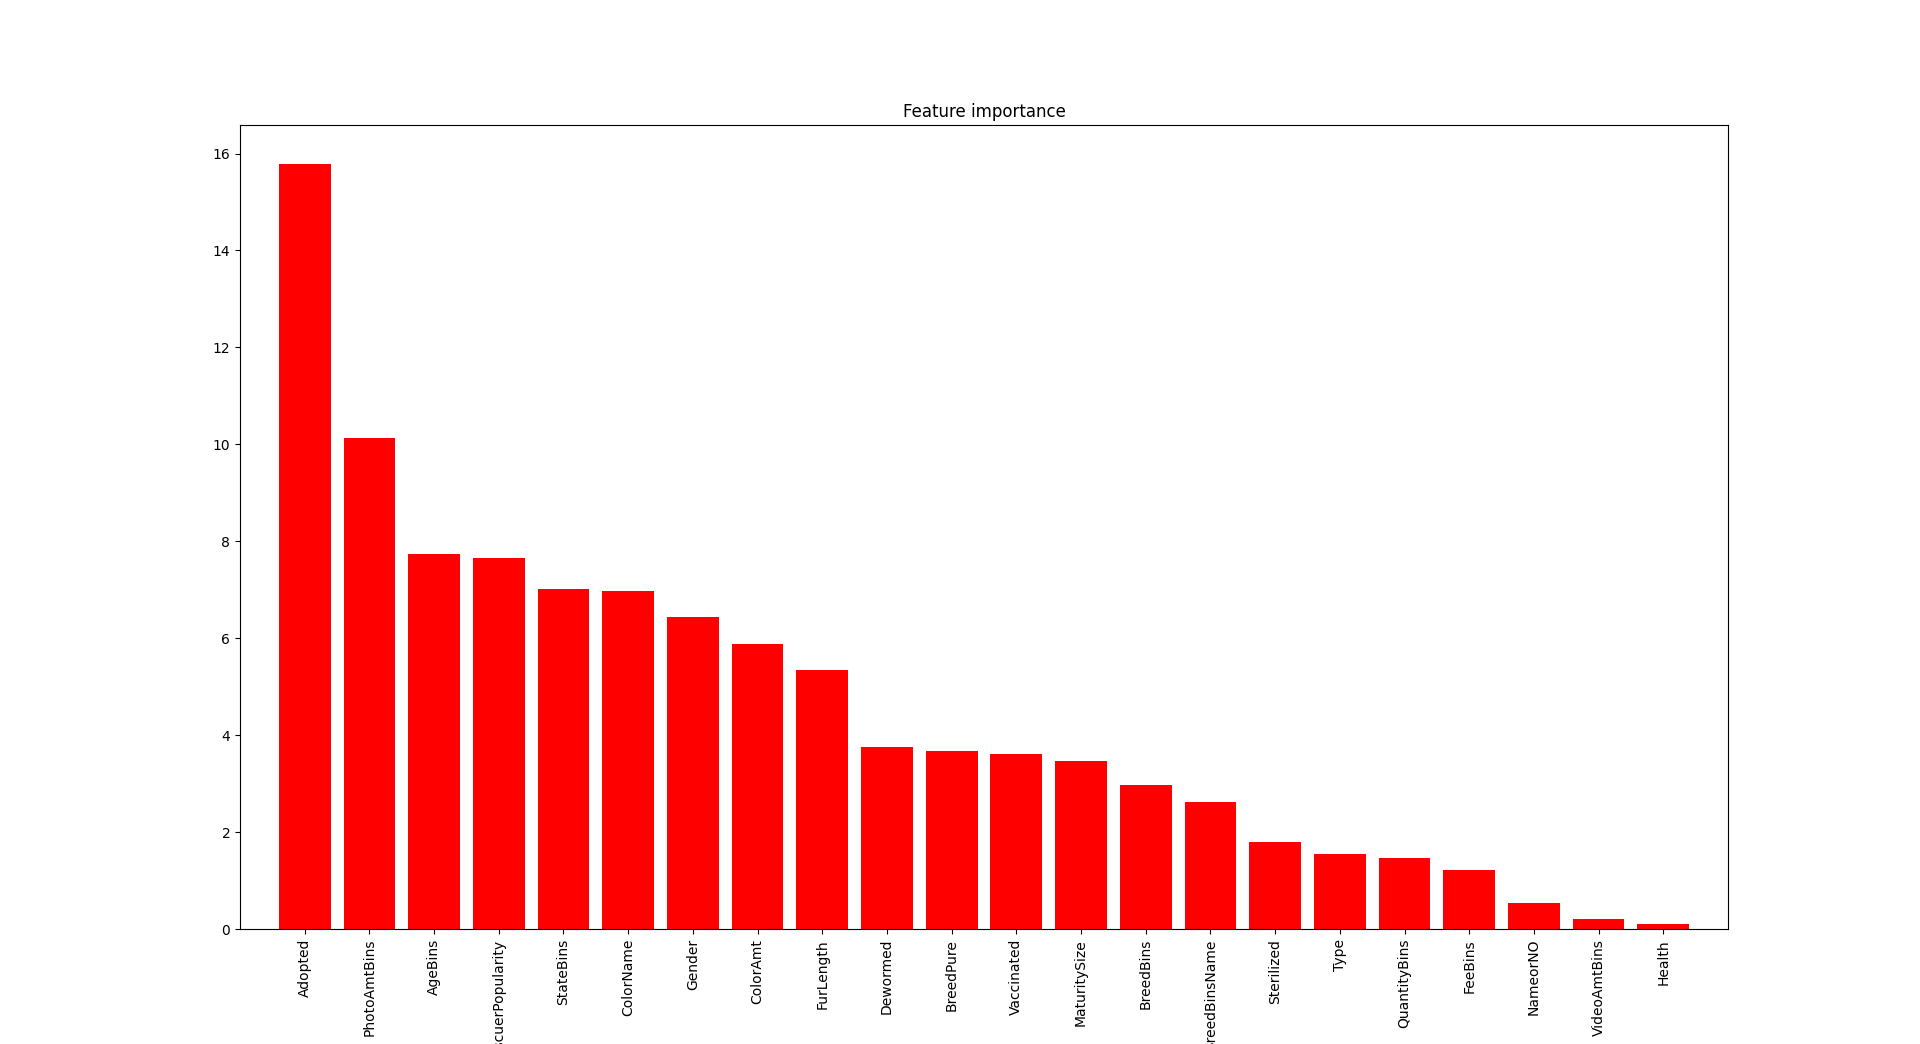

___THE BELOW COUNT PLOT WILL BE USED FOR MAKING RECOMMENDATION IN THE ML PIPELINE THAT WILL BE ADOPTERS PREFERENCE BASED ON THE ABOVE FEATURE IMPORTANCE OBTAINED AFTER MODELLING FROM THE BEST MODEL BEST PARAMETER___

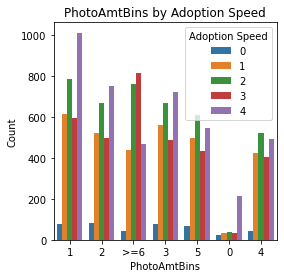

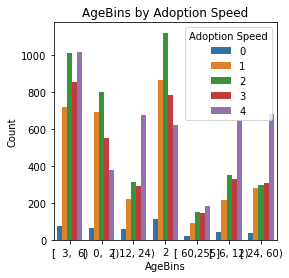

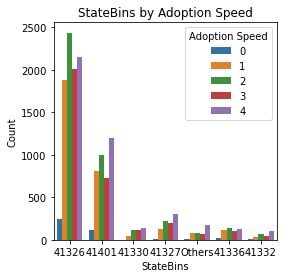

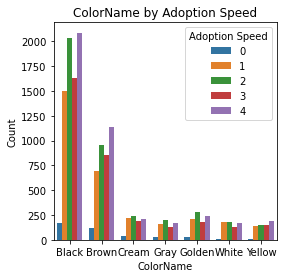

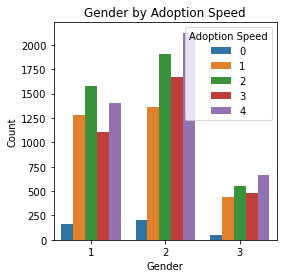

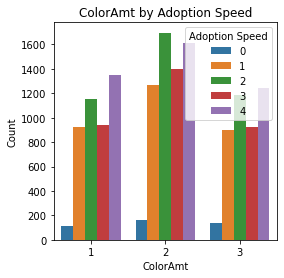

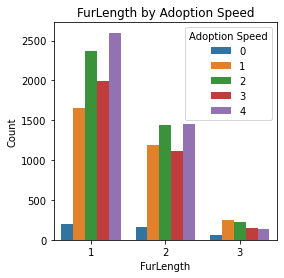

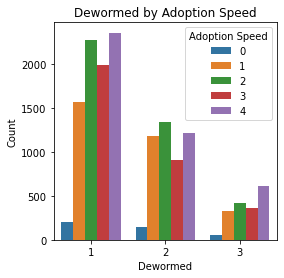

In [14]:
# Select the above 10 impactful columns  and prepare recommendation
cols = ['PhotoAmtBins', 'AgeBins', 'StateBins', 'ColorName', 'Gender', 'ColorAmt', 'FurLength', 'Dewormed']
# Plot the distribution of each feature by adoption speed
for col in cols:
    plt.figure(figsize=(4, 4))
    sns.countplot(x=col, hue='AdoptionSpeed', data=data)
    plt.title(f'{col} by Adoption Speed')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Adoption Speed', loc='upper right')
    plt.show()

___RECOMMENDATION FOR PHOTOAMT___

<div class="alert alert-block alert-info">
     
- Pets with a higher number of photos in their profile tend to get adopted more quickly.
The adoption speed increases with an increase in the number of photos up to 5 photos.
Pets with 6 or more photos show no significant increase in adoption speed compared to pets with 5 photos.

___RECOMMENDATION FOR AGEBINS___

<div class="alert alert-block alert-info">
     
- The adoption speed of pets in the age range of 0-2 years varies widely, with around 700 pets adopted at a speed of 1 but only around 300 pets adopted at a speed of 4.

___RECOMMENDATION FOR STATEBINS___

<div class="alert alert-block alert-info">
    
- The majority of pets in the dataset are located in state with pincode 41326 followed by 41401 and Others.The adoption speed distribution is relatively consistent across different states, with the majority of pets being adopted at a speed of 2 or 4, regardless of their location

___RECOMMENDATION FOR COLORNAME___

<div class="alert alert-block alert-info">
    
- Black is the most common color for adopted pets, followed by brown and cream.Pets with cream-colored fur are more likely to be adopted faster

___RECOMMENDATION FOR GENDER___

<div class="alert alert-block alert-info">
    
- Adoption rates are MORE OR LESS same for male and female pets.The mixed group is very low comparitively

___RECOMMENDATION FOR COLOAMT___

<div class="alert alert-block alert-info">
    
- Animals with one color tend to have a higher adoption rate compared to those with more than one color. the adoption rate tends to decrease as the number of colors on an animal increases.

___RECOMMENDATION FOR FURLENGTH___

<div class="alert alert-block alert-info">
    
- Pets with fur length 1 tend to have higher adoption rates across all adoption speeds compared to pets with fur length 2 or 3.Pets with fur length 1 tend to have higher adoption rates across all adoption speeds compared to pets with fur length 2 or 3.

___RECOMMENDATION FOR DEWORMED___

<div class="alert alert-block alert-info">
    
-Pets that are dewormed have a higher chance of being adopted quickly

In [15]:
summary = data.groupby('State')['Fee'].agg(['mean', 'median', 'std', 'min', 'max'])
summary

,mean,median,std,min,max
State,,,,,
41324,16.576642,0.0,70.661551,0,500
41325,29.563636,0.0,286.147474,0,3000
41326,22.638283,0.0,76.073489,0,1000
41327,16.400949,0.0,55.393501,0,700
41330,13.745238,0.0,63.797894,0,500
41332,14.233202,0.0,47.765434,0,400
41335,31.294118,0.0,117.633291,0,1000
41336,28.641026,0.0,82.860312,0,500
41342,63.846154,0.0,164.799801,0,600


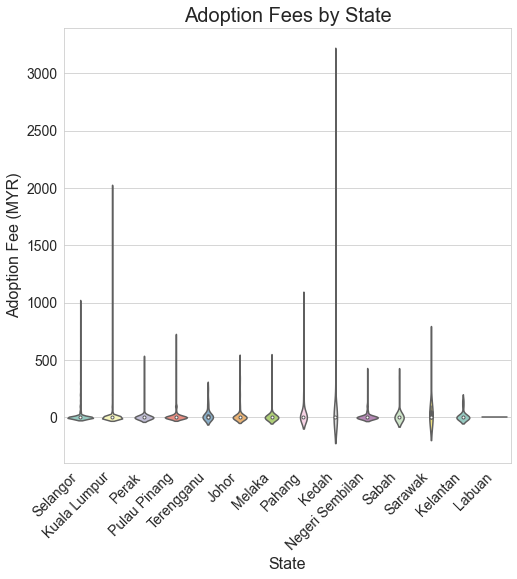

In [16]:
# Adoption Fee by State
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.violinplot(x="StateName", y="Fee", data=data, palette="Set3")
plt.title("Adoption Fees by State", fontsize=20)
plt.xlabel("State", fontsize=16)
plt.ylabel("Adoption Fee (MYR)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

___FEES VARIATION BY STATE FOR DEWORMED___

<div class="alert alert-block alert-info">
    
-For most states, the median adoption fee is 0 dollars, indicating that a significant portion of adoptions are free.he maximum adoption fees across states also vary significantly, ranging from 150 dollars in state 41367 to 3000 dollars in state 41325.The standard deviation of adoption fees also varies greatly among states, ranging from 44.99 dollars in state 41367 to 286.15 dollars in state 41325. This suggests that there is a lot of variation in the adoption fees charged within each state.

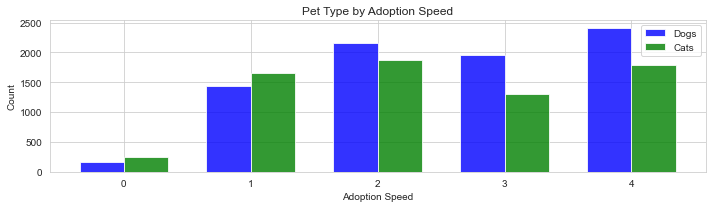

In [17]:
# Create a data frame with the counts of dogs and cats by adoption speed
dog_counts = data[data['Type'] == 1].groupby(['AdoptionSpeed'])['PetID'].count()
cat_counts = data[data['Type'] == 2].groupby(['AdoptionSpeed'])['PetID'].count()
data = pd.DataFrame({'Dogs': dog_counts, 'Cats': cat_counts})
# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(10,3))
bar_width = 0.35
opacity = 0.8
index = np.arange(len(data.index))
rects1 = ax.bar(index, data['Dogs'], bar_width,
                alpha=opacity, color='b', label='Dogs')
rects2 = ax.bar(index + bar_width, data['Cats'], bar_width,
                alpha=opacity, color='g', label='Cats')
ax.set_xlabel('Adoption Speed')
ax.set_ylabel('Count')
ax.set_title('Pet Type by Adoption Speed')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('0', '1', '2', '3', '4'))
ax.legend()
plt.tight_layout()
plt.show()

___CAT VS DOG___

<div class="alert alert-block alert-info">
    
-Dogs have a higher count than cats across almost all adoption speeds.Adoption speed 3 has the lowest counts for both cats and dogs.

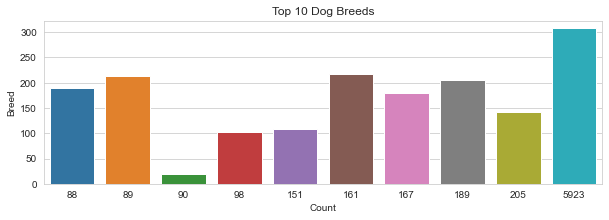

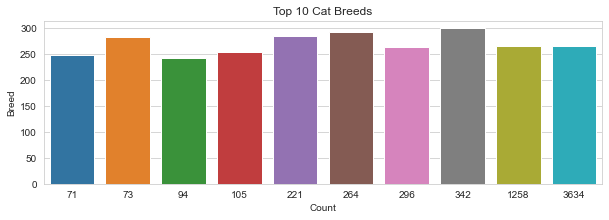

In [18]:
# Load the prepared pets dataset
df = pd.read_csv('/Users/vaishnavikennedy/Downloads/data/pets_prepared.csv')
# Filter by type
dog_df = df[df['Type'] == 1]
cat_df = df[df['Type'] == 2]
# Get the top breeds for each type
dog_breeds = dog_df['Breed1'].value_counts().head(10)
cat_breeds = cat_df['Breed1'].value_counts().head(10)
# Plot the top dog breeds
plt.figure(figsize=(10,3))
sns.barplot(x=dog_breeds.values, y=dog_breeds.index)
plt.title('Top 10 Dog Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')
plt.show()
# Plot the top cat breeds
plt.figure(figsize=(10,3))
sns.barplot(x=cat_breeds.values, y=cat_breeds.index)
plt.title('Top 10 Cat Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')
plt.show()

___Top Dog breed___

<div class="alert alert-block alert-info">
    
- Top Dog breeds in the Df is : 5923 followed by : 161.the least found breed is 90

___Top Cat breed___

<div class="alert alert-block alert-info">
    
- Top Cat breeds in the Df is : 342 followed by : 264. the least found breed is 94